# Adversarial Attacks on Pretrained Models Using FGSM

## Introduction
This project explores the vulnerability of pretrained deep learning models to adversarial attacks, inspired by the foundational 
work "Explaining and Harnessing Adversarial Examples" by Ian J. Goodfellow, Jonathon Shlens, and Christian Szegedy. This follow a tutorial from pytorch (that uses MNIST dataset) https://pytorch.org/tutorials/beginner/fgsm_tutorial.html.


### Objectives:
1. **Evaluate model vulnerabilities:** Test pretrained models such as GoogleNet, VGG11, and ConvNeXt using adversarial examples.
2. **Study the impact of perturbations:** Vary the intensity of attacks by adjusting the epsilon parameter in the FGSM method.
3. **Explore robustness training:** Retrain models with adversarial examples to enhance their resilience.

### What's New?
- **Dataset:** Using a subset of ImageNet (`Imagenette`) for diversity and computational limitations.
- **Models:** Experiments involve state-of-the-art pretrained architectures.
- **Extended Experiments:** Comparative analysis across models and epsilon values, and robustness training evaluation.

### The Notebook Workflow:

The notebook is organized into the following steps:

1. **Adversarial Attack Pipeline Validation**:
   - A single test run is performed to validate the FGSM adversarial attack pipeline.

2. **Comprehensive Analysis**:
   #### 2.1 to 2.3 Combined: Baseline Evaluation, Adversarial Example Generation, and Initial Performance Analysis Under Attack
   - The code block for this section includes:
     - **Baseline Evaluation**: Assess pretrained models on clean images.
     - **Adversarial Example Generation**: Use FGSM to craft adversarial examples.
     - **Model Performance (Partial)**: Analyze initial performance metrics under attack.

   #### 2.4 Detailed Model Performance Analysis
   - Detailed analysis of how model performance degrades under adversarial attack. 

3. **Robustness Training**:
   #### 3.1 Adversarial Example Generation for Training
   - Generate adversarial images for the VGG11 model using FGSM.

   #### 3.2 Retraining the Model
   - Retrain the VGG11 model on the generated adversarial examples.

   #### 3.3 Robustness Testing
   - Evaluate the retrained VGG11 model’s resilience to FGSM attacks by analyzing its performance.

4. **Additional Investigations**:
   #### 4.1 Generalization of Retrained VGG11
   - Assess whether the retrained VGG11 model retains its utility on ImageNet classes not included in its training set.

   #### 4.2 Transferability of Adversarial Examples
   - Examine if adversarial examples generated for VGG11 can also deceive GoogleNet.

   #### 4.3 Exploration of Alternate Attacks
   - Test alternative adversarial attack methods on ConvNeXt, given that FGSM is less effective for this model.


## 1. Adversarial Attack Pipeline Validation:

In [2]:
# Import necessary libraries for adversarial attacks and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision.datasets import ImageFolder
import json
import time
from torchvision.transforms import ToPILImage
import copy
import random 

In [3]:
# This project was run on an M1 Mac Mini. The device is set to use the M1's GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [4]:
# Hyperparameters
epsilons = [0,0.007,0.03,0.07,0.15]
batch_size = 1

In [ ]:
# Load pretrained models
models_list = []
models_list.append(models.googlenet(weights='DEFAULT'))
models_list.append(models.vgg11(weights='DEFAULT'))
models_list.append(models.wide_resnet50_2(weights='DEFAULT'))
models_list.append(models.convnext_tiny(weights='DEFAULT'))

In [5]:
# Set paths
path_to_images = 'Data/imagenette2/val'
path_to_json = 'Data/imagenette2/imagenet_class_index.json'

In [6]:
# Define transforms for the training data and testing data: mean and standard deviation values calculated on ImageNet (see "https://medium.com/@meda.abdullah/transfer-learning-for-computer-vision-a-pytorch-tutorial-c5c4e022bcdf")
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Reverse the transformation
reverse_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]),
])

In [7]:
# Function to recode class definitions to those the model expects in ImageNet
def fix_targets(label):
    dictionary = {0:0, 1: 217, 2: 482, 3: 491, 4:497, 5:566, 6:569, 7:571, 8:574, 9:701}
    return dictionary[label]

In [8]:
# Load and organize images by class, with target label transformations
dataset = datasets.ImageFolder(path_to_images, target_transform=fix_targets)
dataset2 = copy.deepcopy(dataset)  # Create backup copy
dataset.transform = test_transforms  # Apply test-time transformations
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [9]:
def imshow(img):
    """
    Helper function to show an image after converting it from a tensor to a numpy array.
    """
    if img.ndim == 3 and img.shape[0] in {1, 3}:
        img = img.transpose(1, 2, 0)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img)



In [9]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correctly Classified Initially


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9480563998222351 0 0.011067038401961327


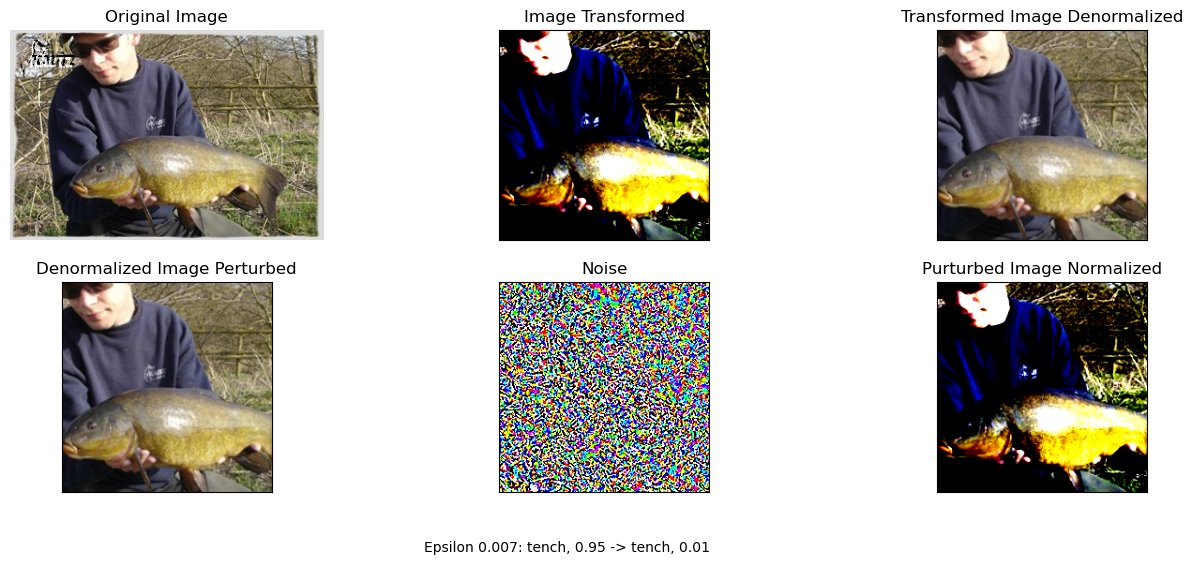

In [10]:
## This code chunk is a single random loop from our training section, it displays an image through the entire transformation procedures. Allowing us to check and visualize the data pipeline.

eps1 = 0.007

j = 0

# Set the model to evaluation mode
model = models_list[0]
model.to(device)
model.eval()
plt.figure(figsize=(16, 6))
criterion = nn.CrossEntropyLoss()

# Plot several examples of adversarial samples at each epsilon
with open(path_to_json, 'r') as f:
    class_info = json.load(f)

for i, (data, target) in enumerate(test_loader):
    # Obtain a random image
    if j <= random.randint(0, 3925):
        j+=1
        continue

    # Display the original image before applying test_transform
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(dataset2[i][0])
    plt.axis('off')  # Hide the axes

    # Display the original image after applying test_transform
    plt.subplot(2, 3, 2)
    numpy_img = data.squeeze().detach().numpy()
    plt.title("Image Transformed")
    imshow(numpy_img)


    # Forward pass the data through the model
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_prob, init_pred = torch.nn.functional.softmax(output, dim=1).max(1) # Apply softmax to convert logits to probabilities for the whole batch

    # If the initial prediction is wrong, don't bother attacking, just move on
    if init_pred.item() != target.item():
        print("Incorrectly Classified Initially")
    else:
        print("Correctly Classified Initially")

    # Calculate the loss
    loss = criterion(output, target)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect ``datagrad``
    data_grad = data.grad.data
    
    # Apply reverse_transform and display image
    data_denorm = reverse_transform(data)
    plt.subplot(2, 3, 3)
    plt.title("Transformed Image Denormalized")
    imshow(data_denorm.squeeze().detach().cpu().numpy()) 

    # Apply the FGSM attack on the immage and display it
    perturbed_data = fgsm_attack(data_denorm, eps1, data_grad)
    plt.subplot(2, 3, 4)
    plt.title("Denormalized Image Perturbed")
    imshow(perturbed_data.squeeze().detach().cpu().numpy()) 

    # Calculate the noise and display it
    noise = perturbed_data - data_denorm
    noise_normalized = (noise - noise.min()) / (noise.max() - noise.min())
    plt.subplot(2, 3, 5)
    plt.title("Noise")
    imshow(noise_normalized.squeeze().detach().cpu().numpy())

    # perturbed_data_normalized = transform(perturbed_data.squeeze(0))

    # Retransform the image and display it
    perturbed_data_normalized = transform(perturbed_data).to(device)
    plt.subplot(2, 3, 6)
    plt.title("Purturbed Image Normalized")
    imshow(perturbed_data_normalized.squeeze().detach().cpu().numpy()) 

    # Re-classify the perturbed image
    output = model(perturbed_data_normalized)

    # Check for success
    final_prob, final_pred = torch.nn.functional.softmax(output, dim=1).max(1)

    print(init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item())
    plt.figtext(0.4, 0.01,f"Epsilon {eps1}: {class_info[str(init_pred.item())][1]}, {init_prob.item():.2f} -> {class_info[str(final_pred.item())][1]}, {final_prob.item():.2f}")
    plt.show()
    break

## 2. Comprehensive Analysis:

### 2.1 to 2.3: Baseline Evaluation and Adversarial Attack

In [ ]:
accuracies, failure_rates, examples = [], [], []

In [75]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    start_time = time.time()
    adv_examples = []

    # Counter for missclassification rate of previously correctly classified images
    sub_total = 0

    # Set the model to evaluation mode
    model.eval()

    # Use the CrossEntropyLoss: models so far have outputed raw logits (unlike tutorial which outputs log probabilites)
    criterion = nn.CrossEntropyLoss()

    # Loop over all examples in test set
    for data, target in test_loader:
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_prob, init_pred = torch.nn.functional.softmax(output, dim=1).max(1) # Apply softmax to convert logits to probabilities for the whole batch, obtain the max probability and the corresponding class

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        sub_total +=1

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = reverse_transform(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transform(perturbed_data).to(device)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_prob, final_pred = torch.nn.functional.softmax(output, dim=1).max(1)
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item(), adv_ex) )
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    failure_rate = 1-correct/sub_total
    print(f"Epsilon: {epsilon}, Test Accuracy = {correct} / {len(test_loader)} = {final_acc: .3f}, Failure Rate =  {sub_total-correct} / {sub_total} = {failure_rate: .3f},  Time taken: {(time.time()-start_time)//60:.0f}m, {(time.time()-start_time)%60:.2f}s")

    # Return the accuracy and an adversarial example
    return final_acc, failure_rate, adv_examples

In [ ]:
# Run test for each epsilon
for i, model in enumerate(models_list):
    model = model.to(device)
    accuracies.append([])
    failure_rates.append([])
    examples.append([])
    for eps in epsilons:
        acc, failure_rate, ex = test(model, device, test_loader, eps)
        accuracies[i].append(acc)
        examples[i].append(ex)
        failure_rates[i].append(failure_rate)

Epsilon: 0, Test Accuracy = 3073 / 3925 =  0.783, Failure Rate =  0 / 3073 =  0.000,  Time taken: 3m, 36.22s
Epsilon: 0.007, Test Accuracy = 498 / 3925 =  0.127, Failure Rate =  2575 / 3073 =  0.838,  Time taken: 3m, 30.68s
Epsilon: 0.03, Test Accuracy = 384 / 3925 =  0.098, Failure Rate =  2689 / 3073 =  0.875,  Time taken: 3m, 22.11s
Epsilon: 0.07, Test Accuracy = 466 / 3925 =  0.119, Failure Rate =  2607 / 3073 =  0.848,  Time taken: 3m, 21.23s
Epsilon: 0.15, Test Accuracy = 277 / 3925 =  0.071, Failure Rate =  2796 / 3073 =  0.910,  Time taken: 3m, 19.59s
Epsilon: 0, Test Accuracy = 3236 / 3925 =  0.824, Failure Rate =  0 / 3236 =  0.000,  Time taken: 6m, 24.20s
Epsilon: 0.007, Test Accuracy = 221 / 3925 =  0.056, Failure Rate =  3015 / 3236 =  0.932,  Time taken: 6m, 22.20s
Epsilon: 0.03, Test Accuracy = 131 / 3925 =  0.033, Failure Rate =  3105 / 3236 =  0.960,  Time taken: 6m, 15.15s
Epsilon: 0.07, Test Accuracy = 118 / 3925 =  0.030, Failure Rate =  3118 / 3236 =  0.964,  Time 

### 2.4 Detailed Model Performance Analysis

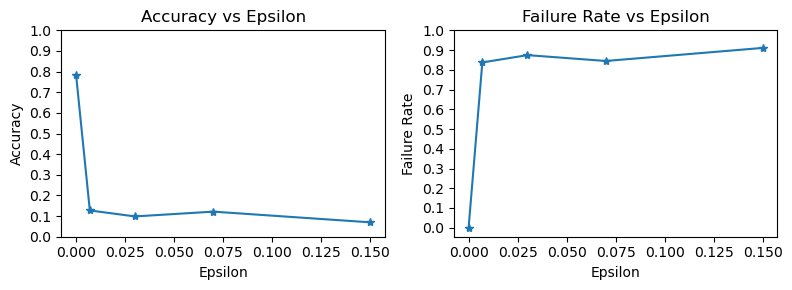

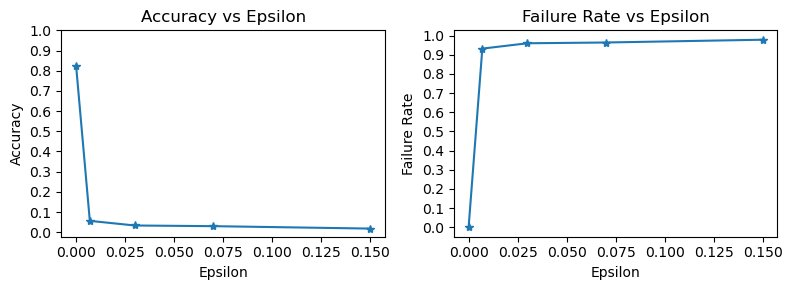

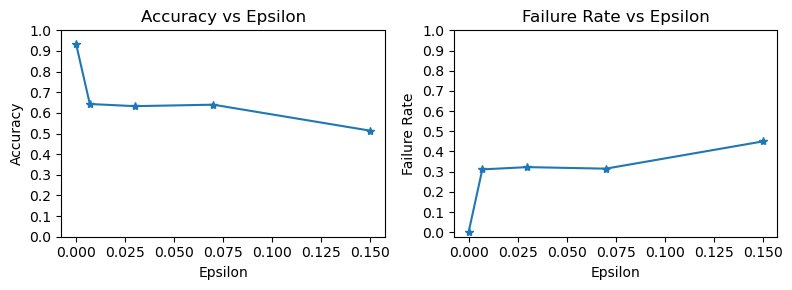

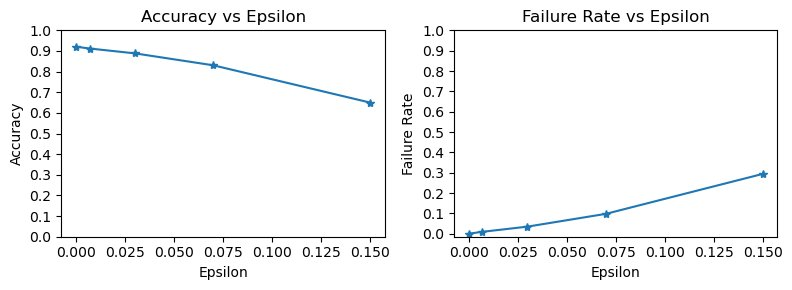

In [ ]:
def plot(accuracies, failure_rates,i):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    # plt.xticks(np.arange(0, .35, step=0.05))
    plt.title(f"Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel(f"Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epsilons, failure_rates, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    # plt.xticks(np.arange(0, .35, step=0.05))
    plt.title(f"Failure Rate vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel(f"Failure Rate")

    plt.tight_layout()  # Adjust layout to make room for elements
    plt.savefig(f'plots_{i}.pdf', )
    plt.show()
for i in range(len(accuracies)):
    plot(accuracies[i], failure_rates[i], i)

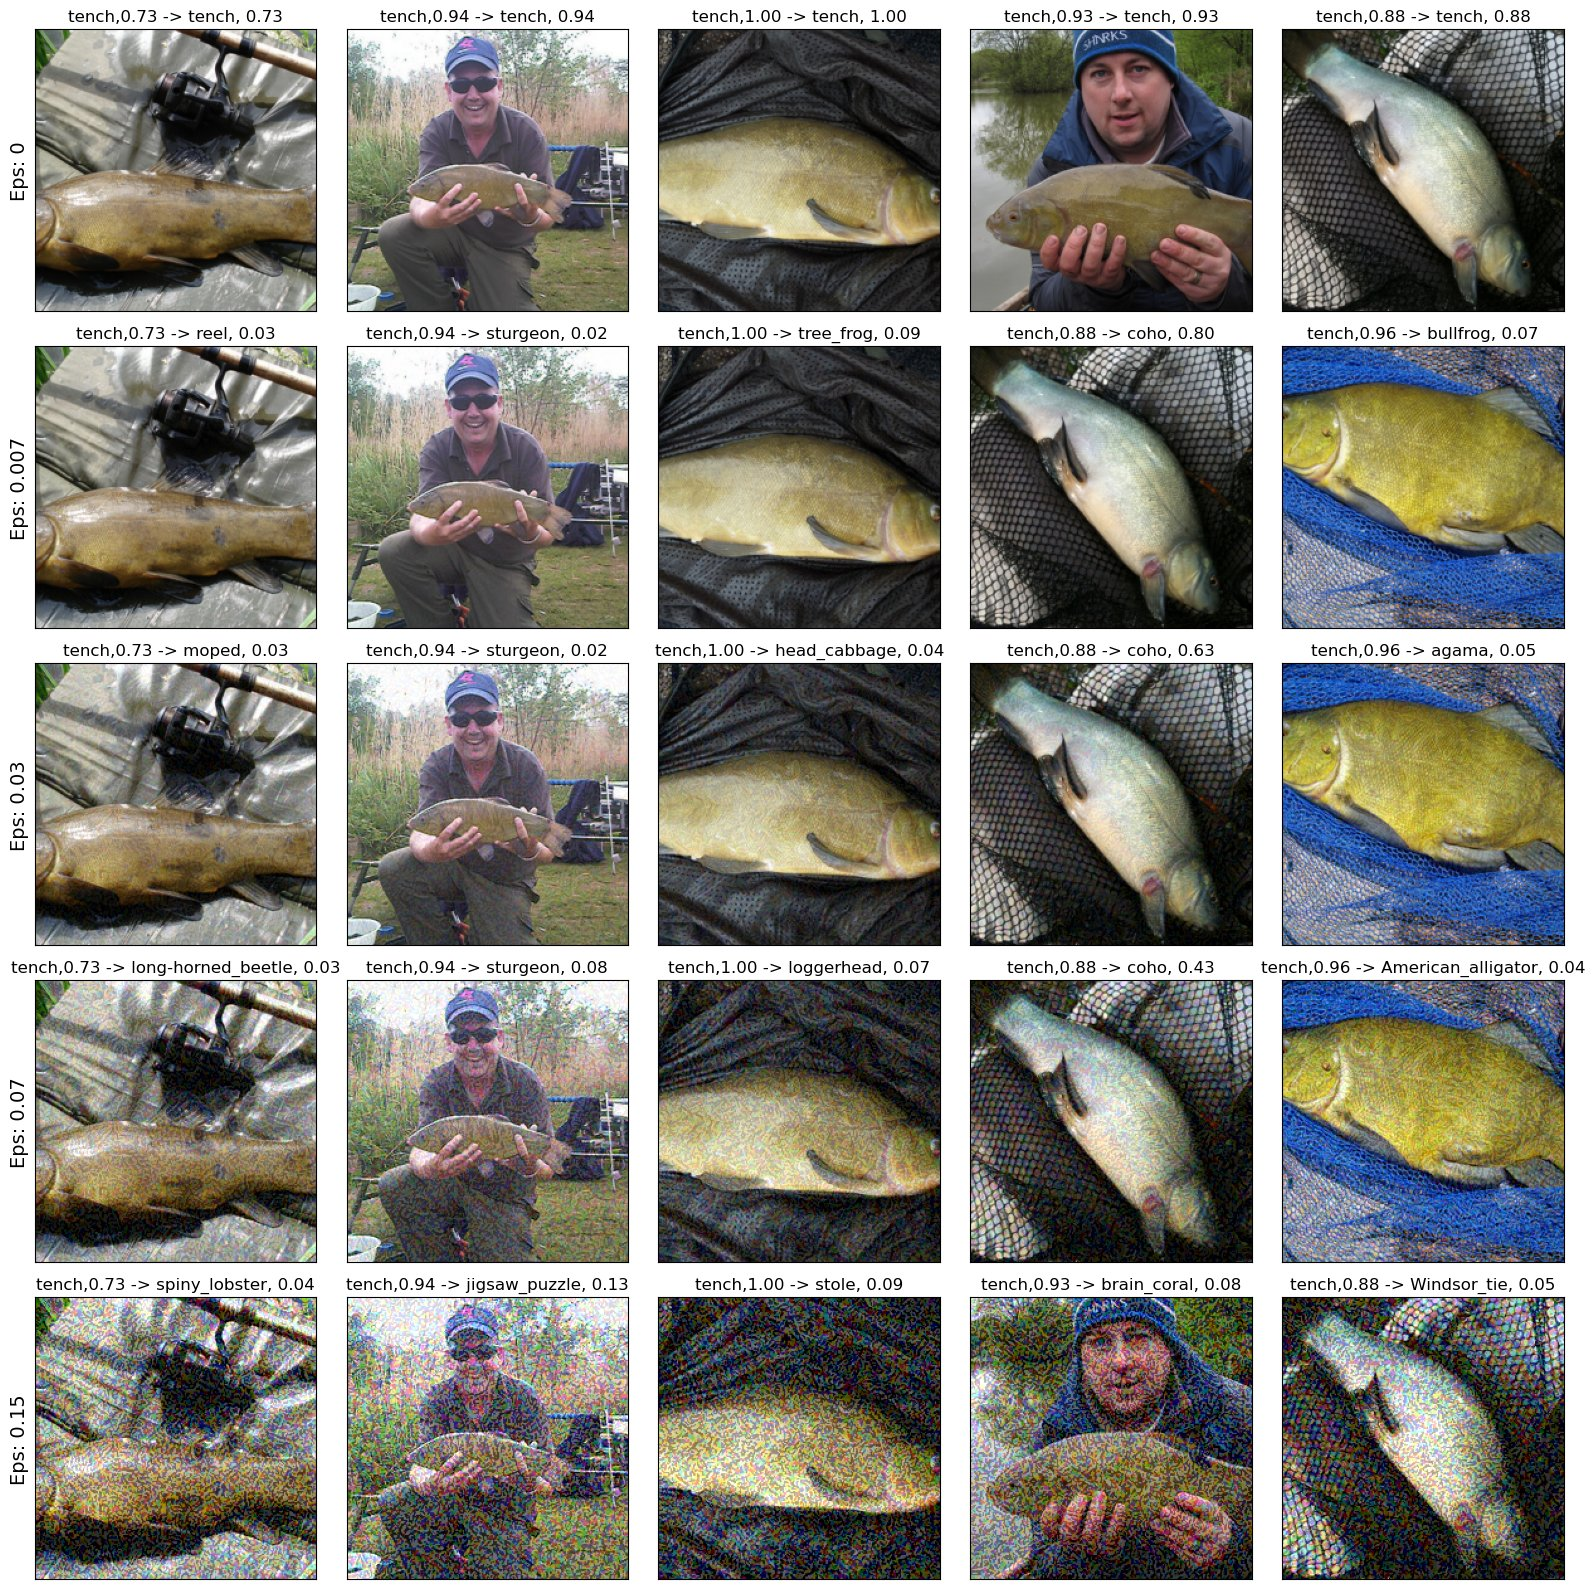

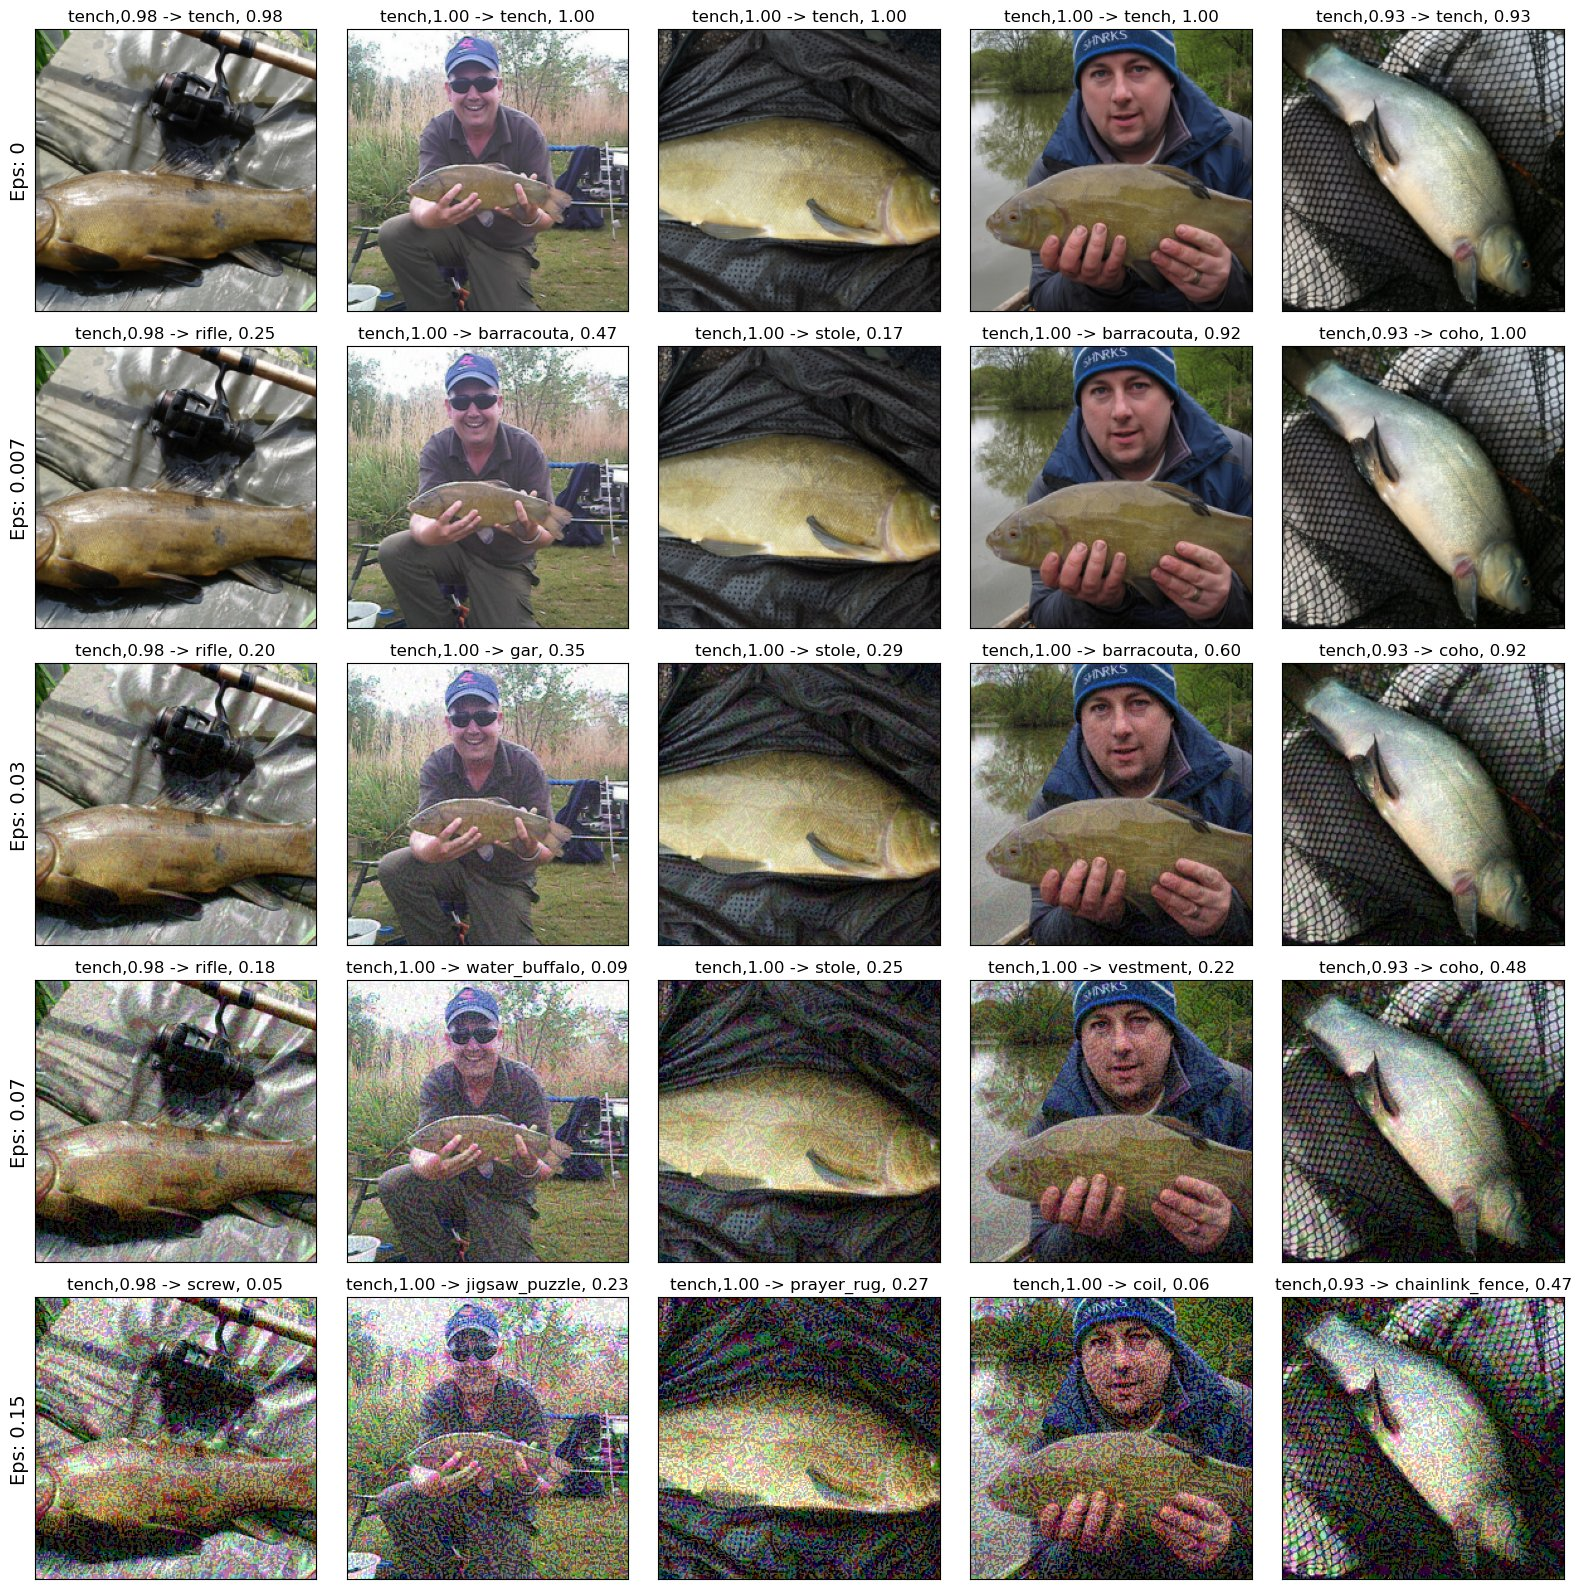

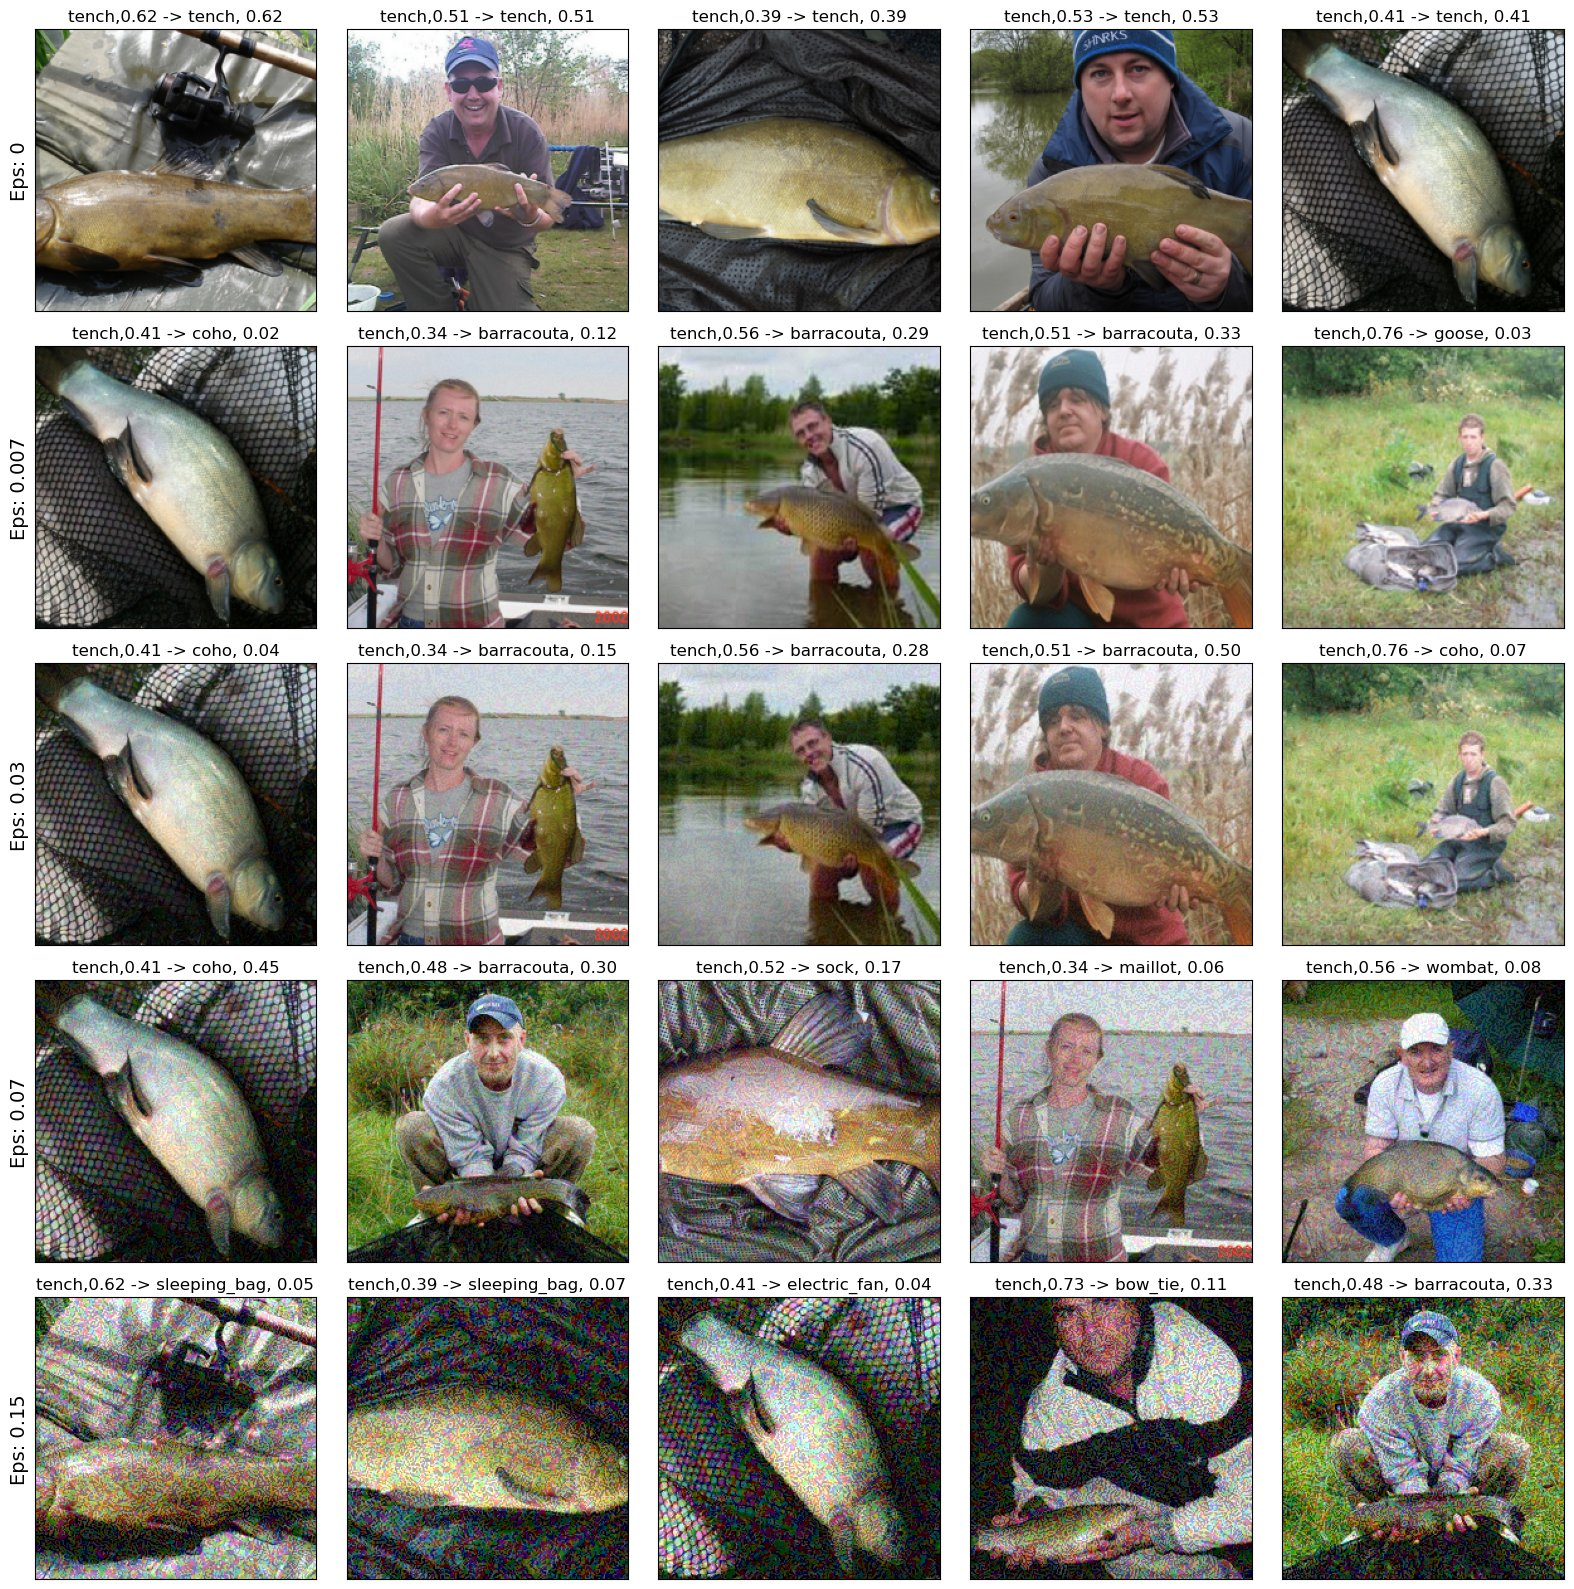

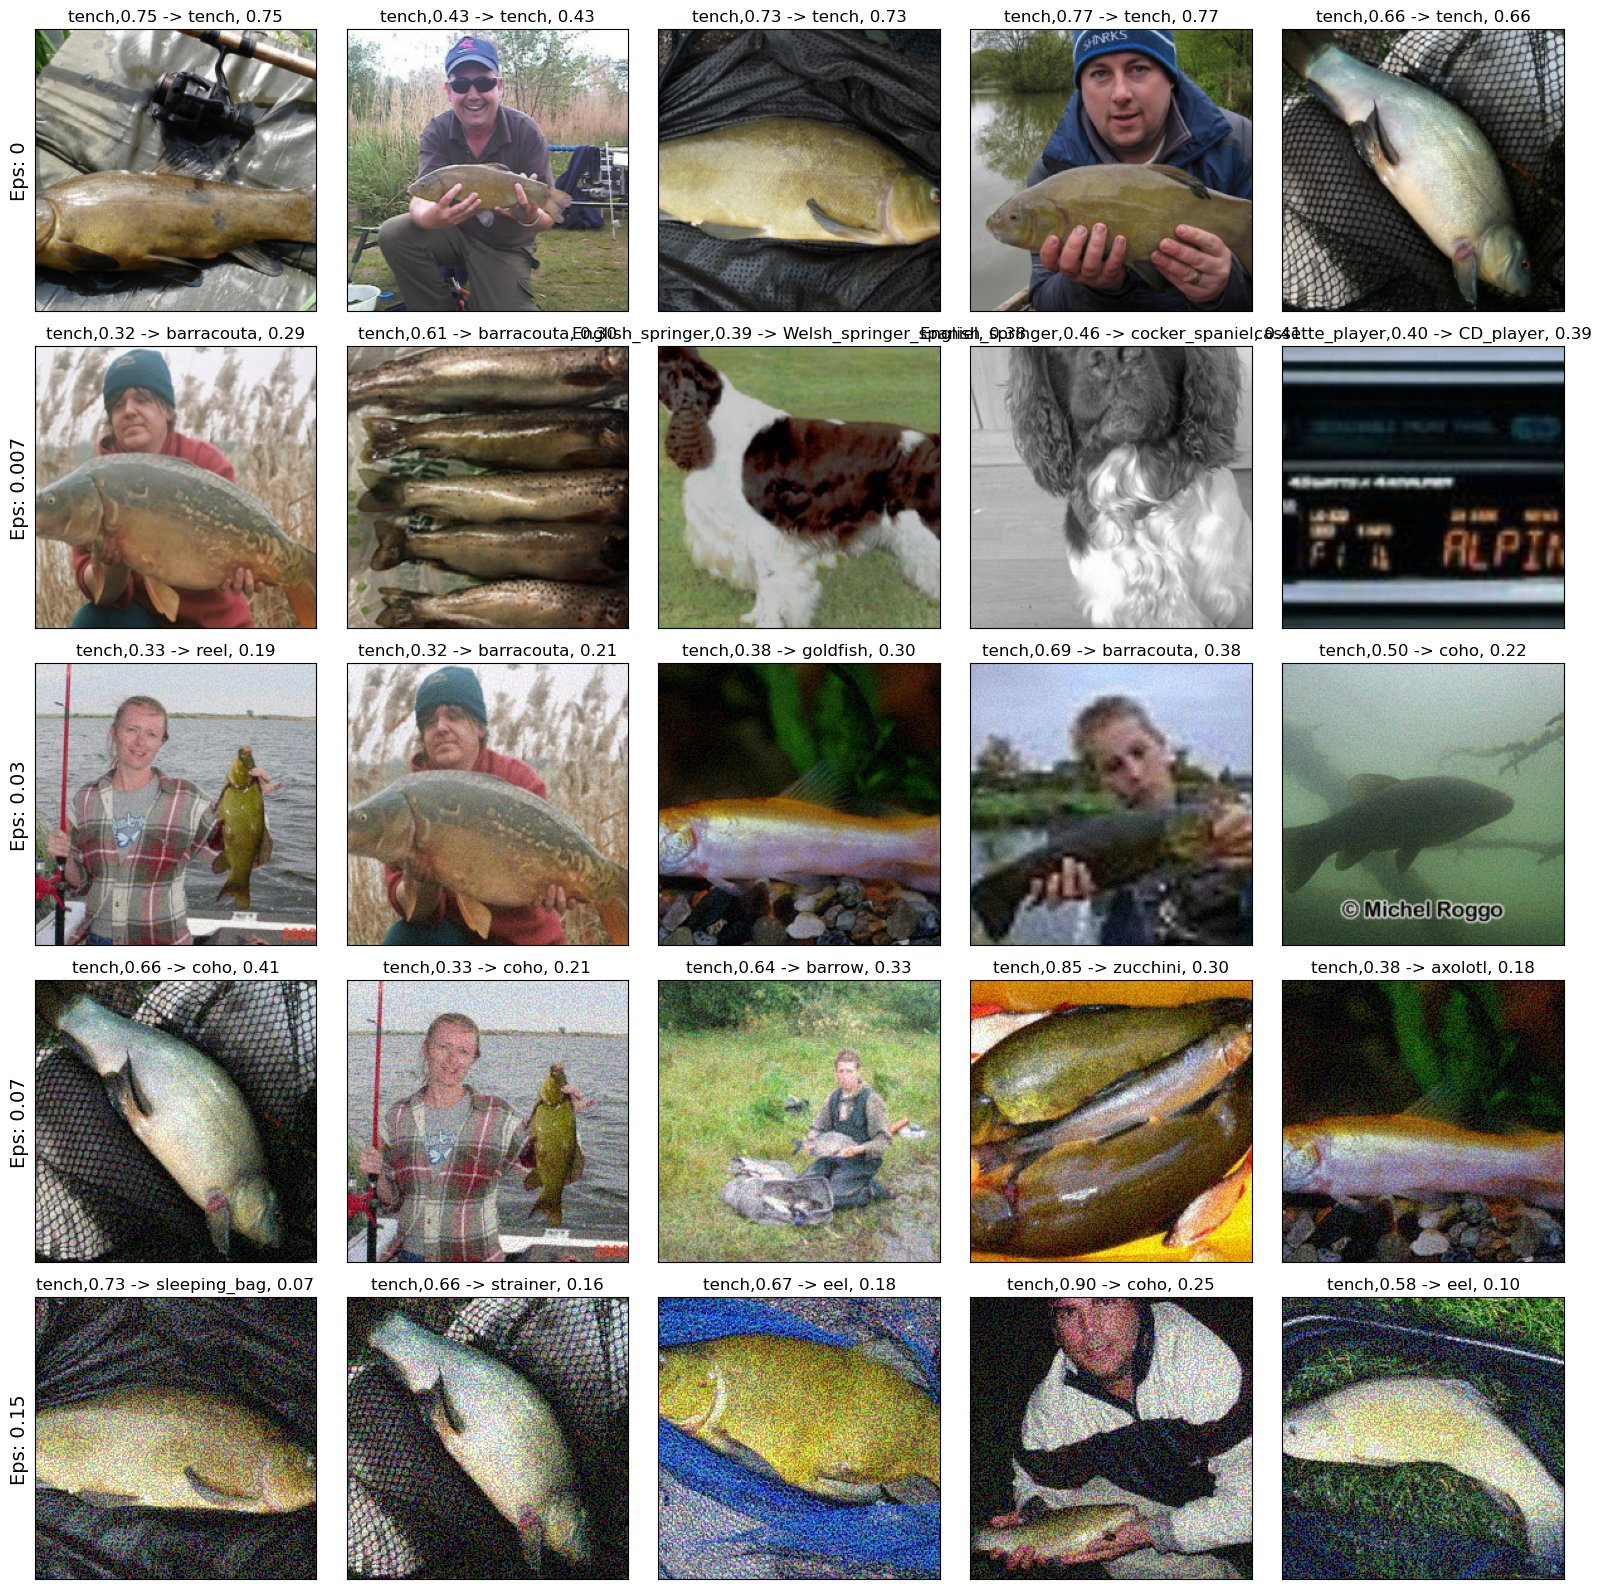

In [ ]:
# Plot several examples of adversarial samples at each epsilon
with open(path_to_json, 'r') as f:
    class_info = json.load(f)

for model in range(len(models_list)):
    cnt = 0
    plt.figure(figsize=(16,16))
    for i in range(len(epsilons)):
        for j in range(len(examples[model][i][-1])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[model][i][-1] ),cnt)
            if j == 0:
                plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
            orig,prob1,adv,prob2,ex = examples[model][i][j]
            plt.title(f"{class_info[str(orig)][1]},{prob1:.2f} -> {class_info[str(adv)][1]}, {prob2:.2f}")
            imshow(ex)
    plt.tight_layout()
    plt.savefig(f'adv_{model}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\n\n\n\n')

## 3. Robustness Training

### 3.1 Adversarial Example Generation

In [2]:
path_to_images = 'Data/imagenette2/train'
path_to_json = 'Data/imagenette2/imagenet_class_index.json'

In [8]:
batch_size = 1
dataset = datasets.ImageFolder(path_to_images, target_transform=fix_targets)
dataset.transform = test_transforms
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [9]:
import os
def gen_adversarial( model, device, test_loader, epsilon = 0.07, save_dir='perturbed_data'):

    start_time = time.time()
    
    # Set the model to evaluation mode
    model.eval()

    # Use the CrossEntropyLoss: models so far have outputed raw logits (unlike tutorial which outputs log probabilites)
    criterion = nn.CrossEntropyLoss()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Loop over all examples in test set
    for batch_idx, (data, target) in enumerate(test_loader):
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = reverse_transform(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        for idx in range(data.size(0)):
            label_dir = os.path.join(save_dir, str(target[idx].item()))
            os.makedirs(label_dir, exist_ok=True)
            torch.save(perturbed_data[idx].detach().cpu(), os.path.join(label_dir, f'data_{batch_idx}_{idx}.pt'))
    
    print(f'Time taken: {(time.time()-start_time)//60:.0f}m, {(time.time()-start_time)%60:.2f}s')

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = models.vgg11(weights='DEFAULT').to(device)

In [ ]:
gen_adversarial(model, device, test_loader, 0.07)

Time taken: 12m, 55.74s


### 3.2 Retraining the Model

In [14]:
from torch.utils.data import Dataset, DataLoader
import os

class TensorFileDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []  # List to hold file paths and corresponding labels

        # Walk through each directory and file
        for dirpath, dirnames, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.endswith('.pt'):
                    # Full path to the file
                    file_path = os.path.join(dirpath, filename)
                    # Label is the directory name, which represents the class
                    label = int(os.path.basename(dirpath))
                    self.samples.append((file_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Retrieve the filepath and label from the samples list
        file_path, label = self.samples[idx]
        tensor = torch.load(file_path)
        return tensor, label


In [ ]:
# Hyperparameters:
batch_size = 32
number_epochs = 20
learning_rate = 0.0001
step = 7
gamma = 0.1
model = models.vgg11(weights='DEFAULT').to(device)

In [ ]:
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
perturbed_dataset = TensorFileDataset('perturbed_data')
perturbed_dataset.transform = transform
unperturbed_dataset = datasets.ImageFolder(path_to_images, target_transform=fix_targets, transform = test_transforms)
combined_dataset = ConcatDataset([unperturbed_dataset, perturbed_dataset])

train_size = int(0.8 * len(combined_dataset))  # 80% for training
val_size = len(combined_dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Set requires_grad=False for all parameters except those in the classifier
for param in model.parameters():
    param.requires_grad = False

# Set requires_grad=True for parameters in the classifier
for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
def train():

    start_time_model = time.time()
    
    running_loss = 0

    training_losses = []
    trianing_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=3, verbose=True, path='model_checkpoint.pt')

    # Loop over the epochs
    for epoch in range(number_epochs):
        
        
        # Loop over the training data loader
        correct = 0
        total = 0
        model.train()
        start_time = time.time()
        for inputs, labels in trainloader:
            # Move inputs and labels to the appropriate device (e.g., GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        training_losses.append(epoch_loss)
        accuracy = correct / total
        trianing_accuracies.append(accuracy)
        
        # Evaluation on the validation set
        model.eval()
        test_loss = 0
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate accuracy after the inner loop ends
        accuracy = correct / total
        val_epoch_loss = test_loss / len(testloader)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(accuracy)

        scheduler.step()

        time_elapsed = time.time()-start_time

        print(f"Epoch {epoch+1}/{number_epochs}, "
                f"Train loss: {running_loss/len(trainloader):.3f}, "
                f"Train accuracy: {trianing_accuracies[-1]:.3f}, "
                f"Test loss: {test_loss/len(testloader):.3f}, "
                f"Test accuracy: {accuracy:.3f}, "
                f'Time taken: {time_elapsed//60:.0f}m {time_elapsed %60:.0f}s')
        running_loss = 0

        # Early stopping call
        early_stopping(val_epoch_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    total_time_elapsed = time.time()-start_time_model
    print(f'Total Time: {total_time_elapsed//60:.0f}m {total_time_elapsed %60:.0f}s')
    torch.save(model, 'model_complete.pth')
    return training_losses, trianing_accuracies, val_losses, val_accuracies

In [ ]:
training_losses1, trianing_accuracies1, val_losses1, val_accuracies1 = train()

Epoch 1/20, Train loss: 0.019, Train accuracy: 0.828, Test loss: 0.387, Test accuracy: 0.879, Time taken: 5m 36s
Validation loss decreased (inf --> 0.012152).  Saving model ...
Epoch 2/20, Train loss: 0.007, Train accuracy: 0.925, Test loss: 0.363, Test accuracy: 0.888, Time taken: 5m 32s
Validation loss decreased (0.012152 --> 0.011398).  Saving model ...
Epoch 3/20, Train loss: 0.003, Train accuracy: 0.973, Test loss: 0.404, Test accuracy: 0.898, Time taken: 5m 36s
EarlyStopping counter: 1 out of 3
Epoch 4/20, Train loss: 0.001, Train accuracy: 0.985, Test loss: 0.553, Test accuracy: 0.873, Time taken: 5m 36s
EarlyStopping counter: 2 out of 3
Epoch 5/20, Train loss: 0.002, Train accuracy: 0.982, Test loss: 0.475, Test accuracy: 0.897, Time taken: 5m 38s
EarlyStopping counter: 3 out of 3
Early stopping
Total Time: 28m 8s


In [ ]:
def plotting_model(tuning, training_losses, training_accuracies, val_losses, val_accuracies):
    # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))  # Adjusted figsize for better aspect ratio

    # Plot training and validation losses on the first subplot
    axs[0].plot(range(1, len(training_losses)+1), training_losses, label=f"Training Loss")
    axs[0].plot(range(1, len(val_losses)+1), val_losses, label=f"Validation Loss")
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Loss vs Epochs')
    axs[0].legend()

    # Plot training and validation accuracies on the second subplot
    axs[1].plot(range(1, len(training_accuracies)+1), training_accuracies, label=f"Training Accuracy")
    axs[1].plot(range(1, len(val_accuracies)+1), val_accuracies, label=f"Validation Accuracy")
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training and Validation Accuracy vs Epochs')
    axs[1].legend()

    # Automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout()

    # Save the figure to a file
    plt.savefig(f'plots_{tuning}.pdf')  # Choose format and filename appropriately

    # Display the plot
    plt.show()


In [ ]:
import pickle
# Combining the lists into a tuple
data_to_save = (training_losses1, trianing_accuracies1, val_losses1, val_accuracies1)
# Saving the combined object to a file
with open('lists_retraining.pkl', 'wb') as pkl_file:
    pickle.dump(data_to_save, pkl_file)


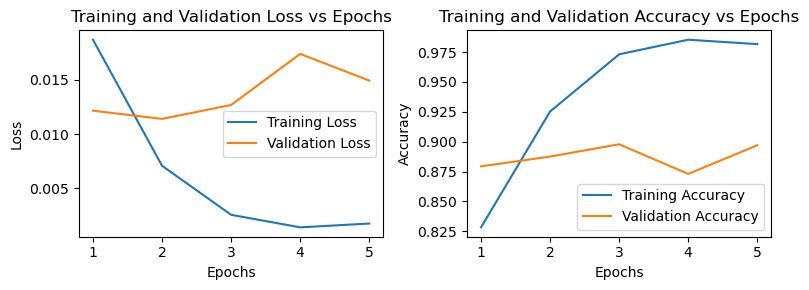

In [ ]:
plotting_model('Partial Fine Tuning', training_losses1, trianing_accuracies1, val_losses1, val_accuracies1)

### 3.3 Robustness Testing

In [ ]:
model = torch.load('model_complete.pth')

In [ ]:
model.load_state_dict(torch.load('model_checkpoint.pt'))

<All keys matched successfully>

In [ ]:
path_to_images = 'Data/imagenette2/val'
batch_size = 1
dataset = datasets.ImageFolder(path_to_images, target_transform=fix_targets)
dataset.transform = test_transforms
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    start_time = time.time()
    adv_examples = []

    # Counter for missclassification rate of previously correctly classified images
    sub_total = 0

    # Set the model to evaluation mode
    model.eval()

    # Use the CrossEntropyLoss: models so far have outputed raw logits (unlike tutorial which outputs log probabilites)
    criterion = nn.CrossEntropyLoss()

    # Loop over all examples in test set
    for data, target in test_loader:
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_prob, init_pred = torch.nn.functional.softmax(output, dim=1).max(1) # Apply softmax to convert logits to probabilities for the whole batch, obtain the max probability and the corresponding class

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        sub_total +=1

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = reverse_transform(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transform(perturbed_data).to(device)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_prob, final_pred = torch.nn.functional.softmax(output, dim=1).max(1)
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item(), adv_ex) )
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    failure_rate = 1-correct/sub_total
    print(f"Epsilon: {epsilon}, Test Accuracy = {correct} / {len(test_loader)} = {final_acc: .3f}, Failure Rate =  {sub_total-correct} / {sub_total} = {failure_rate: .3f},  Time taken: {(time.time()-start_time)//60:.0f}m, {(time.time()-start_time)%60:.2f}s")

    # Return the accuracy and an adversarial example
    return final_acc, failure_rate, adv_examples

In [ ]:
epsilons = [0,0.007,0.03,0.07,0.15]
accuracies, failure_rates, examples = [],[],[]

In [ ]:
model = model.to(device)
for eps in epsilons:
    acc, failure_rate, ex = test(model, device, test_loader, eps)
    accuracies[0].append(acc)
    examples[0].append(ex)
    failure_rates[0].append(failure_rate)

Epsilon: 0, Test Accuracy = 3811 / 3925 =  0.971, Failure Rate =  0 / 3811 =  0.000,  Time taken: 5m, 43.60s
Epsilon: 0.007, Test Accuracy = 2369 / 3925 =  0.604, Failure Rate =  1442 / 3811 =  0.378,  Time taken: 5m, 34.31s
Epsilon: 0.03, Test Accuracy = 2262 / 3925 =  0.576, Failure Rate =  1549 / 3811 =  0.406,  Time taken: 5m, 40.84s
Epsilon: 0.07, Test Accuracy = 2350 / 3925 =  0.599, Failure Rate =  1461 / 3811 =  0.383,  Time taken: 5m, 34.62s
Epsilon: 0.15, Test Accuracy = 2239 / 3925 =  0.570, Failure Rate =  1572 / 3811 =  0.412,  Time taken: 5m, 32.75s


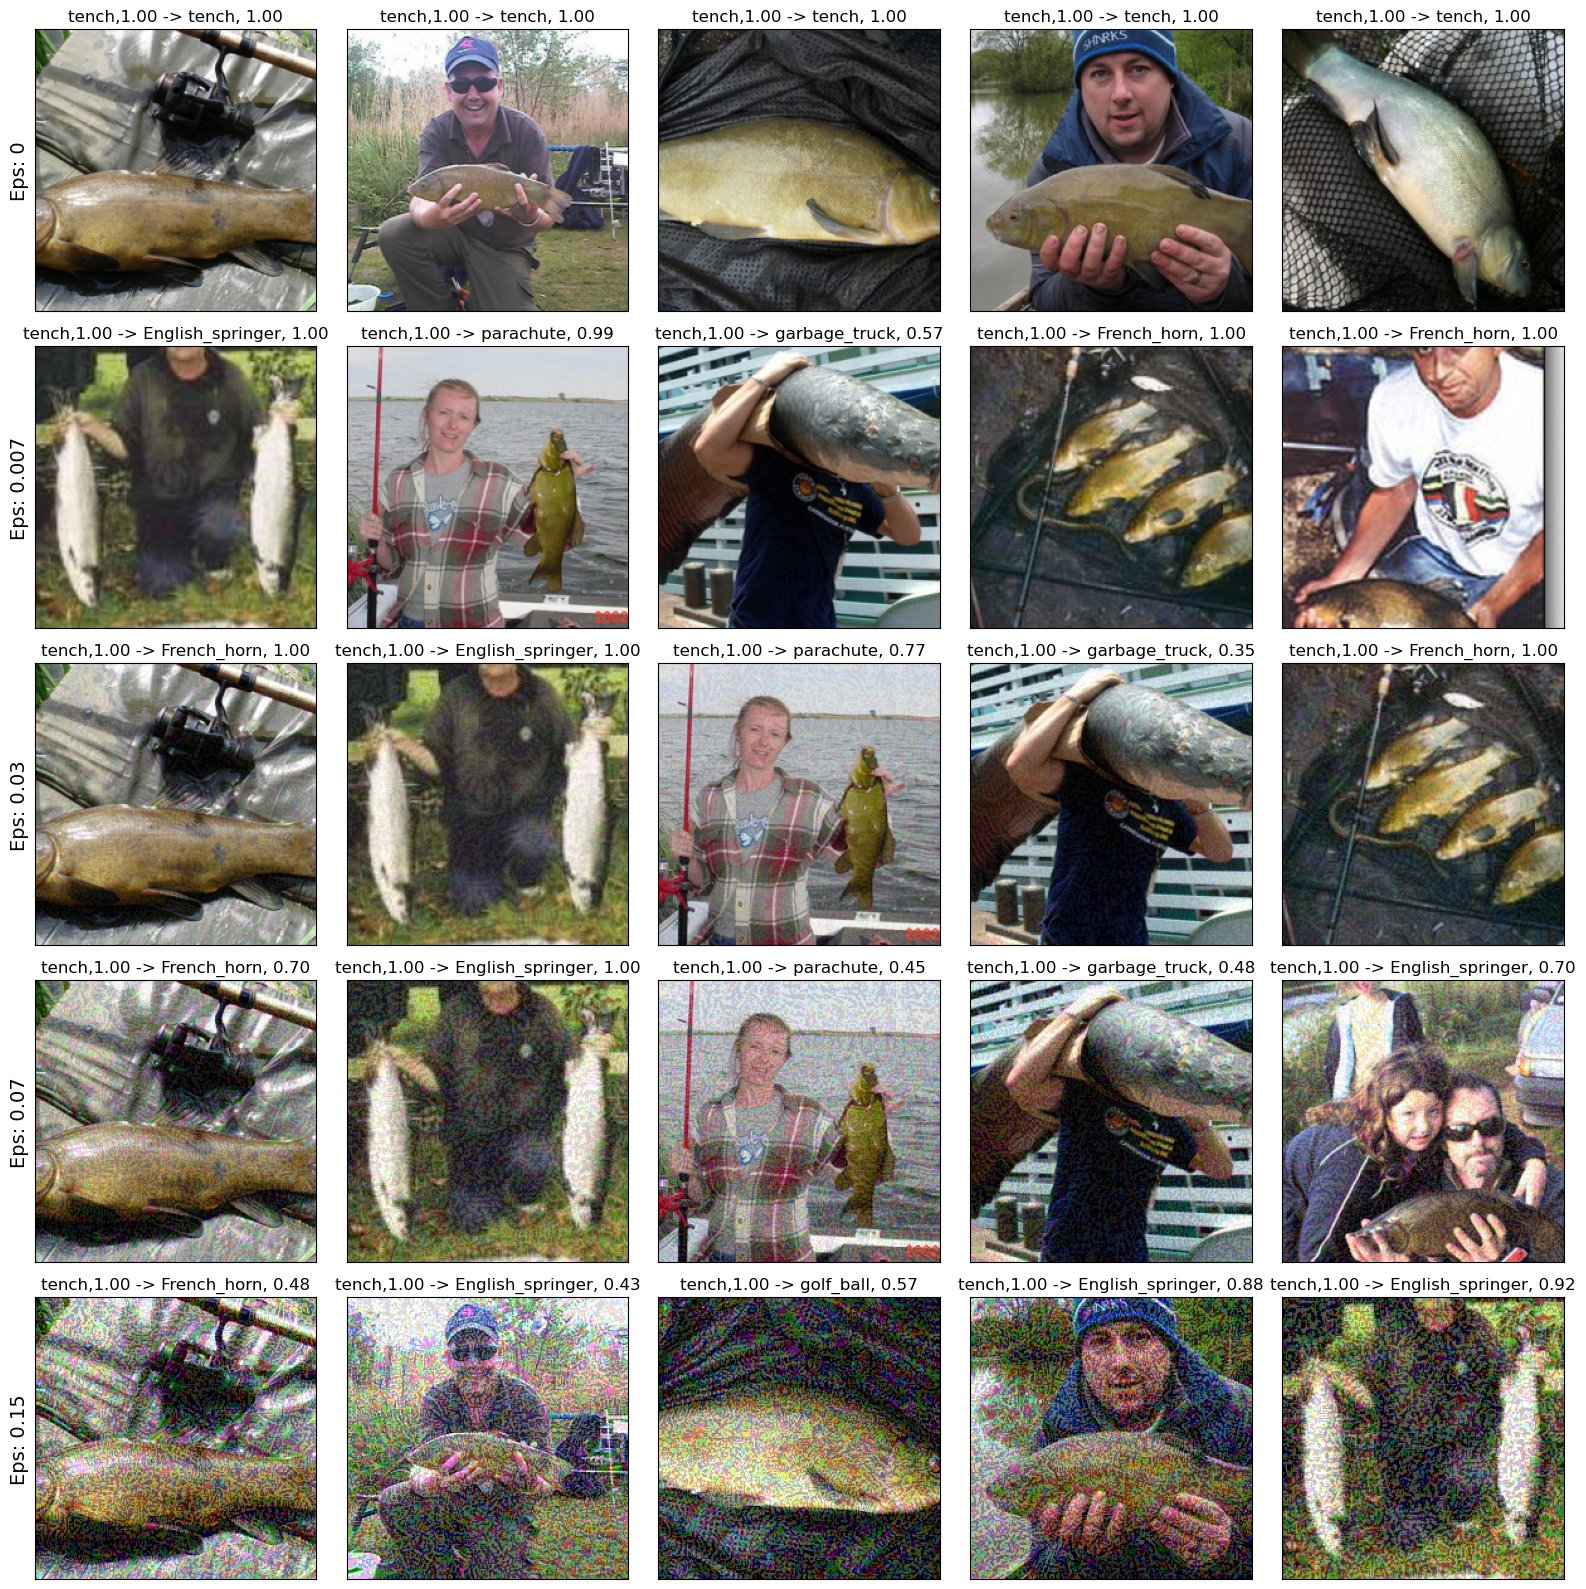

In [ ]:
# Plot several examples of adversarial samples at each epsilon
with open(path_to_json, 'r') as f:
    class_info = json.load(f)

for model in range(1):
    cnt = 0
    plt.figure(figsize=(16,16))
    for i in range(len(epsilons)):
        for j in range(len(examples[model][i][-1])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[model][i][-1] ),cnt)
            if j == 0:
                plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
            # orig,adv,ex = examples[i][j]
            orig,prob1,adv,prob2,ex = examples[model][i][j]
            plt.title(f"{class_info[str(orig)][1]},{prob1:.2f} -> {class_info[str(adv)][1]}, {prob2:.2f}")
            # plt.title(f"{prob1} -> {prob2}")
            imshow(ex)
    plt.tight_layout()
    plt.savefig(f'adv_retrained.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('\n\n\n\n')

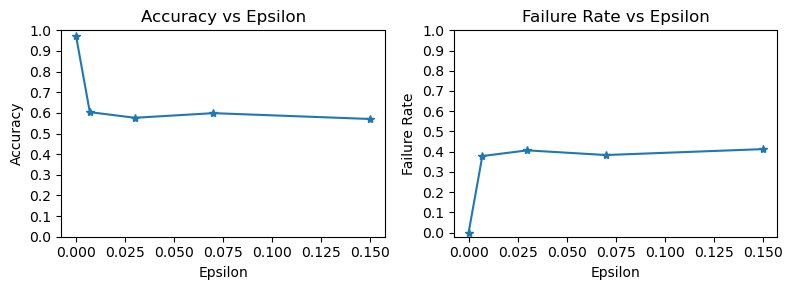

In [ ]:
def plot(accuracies, failure_rates,i):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    # plt.xticks(np.arange(0, .35, step=0.05))
    plt.title(f"Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel(f"Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epsilons, failure_rates, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    # plt.xticks(np.arange(0, .35, step=0.05))
    plt.title(f"Failure Rate vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel(f"Failure Rate")

    plt.tight_layout()  # Adjust layout to make room for elements
    plt.savefig(f'plots_retrained.pdf')
    plt.show()
for i in range(len(accuracies)):
    plot(accuracies[i], failure_rates[i], i)

## 4. Additional Investigations

### 4.1 Generalization of Retrained VGG11

In [ ]:
import json

# def fix_targets(label):

# This is your JSON data as a string for example purposes
with open(path_to_json, 'r') as f:
    json_data = json.load(f)

# Function to create a mapping from the keys in the JSON to sequential integers
def create_mapping(json_data):
    return {json_data[key][0]: int(key) for key in json_data}

# Using the function to create the dictionary
mapping_dict = create_mapping(json_data)

In [ ]:
path_to_images = 'Data/imagenet-mini/val'
batch_size = 1
dataset = datasets.ImageFolder(path_to_images)
dataset.transform = test_transforms
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = models.vgg11(weights='DEFAULT').to(device)
model.load_state_dict(torch.load('model_checkpoint.pt'))

<All keys matched successfully>

In [ ]:
len(dataset2)

3923

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Incorrectly Classified Initially
0 0.6611891388893127 574 0.8759574294090271


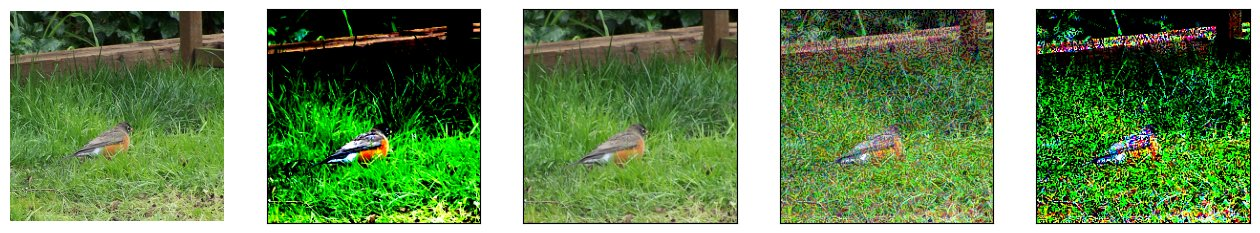

In [ ]:
## This code chunk is a single random loop from our training section, it displays an image through the entire transformation procedures. Allowing us to perform a check.

eps1 = 0.15

j = 0

# Set the model to evaluation mode
model.to(device)
model.eval()
plt.figure(figsize=(16, 3))
criterion = nn.CrossEntropyLoss()

for i, (data, target) in enumerate(test_loader):
    # Obtain a random image
    if j <= random.randint(0, 3925):
        j+=1
        continue

    # Display the original image before applying test_transform
    plt.subplot(1, 5, 1)
    plt.imshow(dataset2[i][0])
    plt.axis('off')  # Hide the axes

    # Display the original image after applying test_transform
    plt.subplot(1, 5, 2)
    numpy_img = data.squeeze().detach().numpy()
    imshow(numpy_img)


    # Forward pass the data through the model
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_prob, init_pred = torch.nn.functional.softmax(output, dim=1).max(1) # Apply softmax to convert logits to probabilities for the whole batch

    # If the initial prediction is wrong, don't bother attacking, just move on
    if init_pred.item() != target.item():
        print("Incorrectly Classified Initially")
    else:
        print("Correctly Classified Initially")

    # Calculate the loss
    loss = criterion(output, target)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect ``datagrad``
    data_grad = data.grad.data
    
    # Apply reverse_transform and display image
    data_denorm = reverse_transform(data)
    plt.subplot(1, 5, 3)
    imshow(data_denorm.squeeze().detach().cpu().numpy()) 

    # Apply the FGSM attack on the immage and display it
    perturbed_data = fgsm_attack(data_denorm, eps1, data_grad)
    plt.subplot(1, 5, 4)
    imshow(perturbed_data.squeeze().detach().cpu().numpy()) 

    # perturbed_data_normalized = transform(perturbed_data.squeeze(0))

    # Retransform the image and display it
    perturbed_data_normalized = transform(perturbed_data).to(device)
    plt.subplot(1, 5, 5)
    imshow(perturbed_data_normalized.squeeze().detach().cpu().numpy()) 

    # Re-classify the perturbed image
    output = model(perturbed_data_normalized)

    # Check for success
    final_prob, final_pred = torch.nn.functional.softmax(output, dim=1).max(1)

    print(init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item())
    plt.show()
    break

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    start_time = time.time()
    adv_examples = []

    # Counter for missclassification rate of previously correctly classified images
    sub_total = 0

    # Set the model to evaluation mode
    model.eval()

    # Use the CrossEntropyLoss: models so far have outputed raw logits (unlike tutorial which outputs log probabilites)
    criterion = nn.CrossEntropyLoss()

    # Loop over all examples in test set
    for data, target in test_loader:
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_prob, init_pred = torch.nn.functional.softmax(output, dim=1).max(1) # Apply softmax to convert logits to probabilities for the whole batch, obtain the max probability and the corresponding class

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        sub_total +=1

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = reverse_transform(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transform(perturbed_data).to(device)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_prob, final_pred = torch.nn.functional.softmax(output, dim=1).max(1)
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item(), adv_ex) )
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    failure_rate = 1-correct/sub_total
    print(f"Epsilon: {epsilon}, Test Accuracy = {correct} / {len(test_loader)} = {final_acc: .3f}, Failure Rate =  {sub_total-correct} / {sub_total} = {failure_rate: .3f},  Time taken: {(time.time()-start_time)//60:.0f}m, {(time.time()-start_time)%60:.2f}s")

    # Return the accuracy and an adversarial example
    return final_acc, failure_rate, adv_examples

In [ ]:
model = model.to(device)
accuracies= []
failure_rates= []
examples = []
for eps in range(1):
    acc, failure_rate, ex = test(model, device, test_loader, 0.007)
    accuracies.append(acc)
    examples.append(ex)
    failure_rates.append(failure_rate)

Epsilon: 0.007, Test Accuracy = 29 / 3923 =  0.007, Failure Rate =  122 / 151 =  0.808,  Time taken: 2m, 10.88s


### 4.2 Transferability of Adversarial Examples

In [15]:
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
path_to_images = 'Data/imagenette2/train'
perturbed_dataset = TensorFileDataset('perturbed_data')
perturbed_dataset.transform = transform
unperturbed_dataset = datasets.ImageFolder(path_to_images, target_transform=fix_targets, transform = test_transforms)

In [16]:
len(perturbed_dataset)

9469

In [17]:
from torch.utils.data import Dataset

class PairedDataset(Dataset):
    def __init__(self, unperturbed_dataset, perturbed_dataset):
        assert len(unperturbed_dataset) == len(perturbed_dataset), "Datasets must be of the same size"
        self.unperturbed_dataset = unperturbed_dataset
        self.perturbed_dataset = perturbed_dataset
    
    def __getitem__(self, index):
        unperturbed_data, target = self.unperturbed_dataset[index]
        perturbed_data, _ = self.perturbed_dataset[index]
        return (unperturbed_data, perturbed_data), target
    
    def __len__(self):
        return len(self.unperturbed_dataset)

paired_dataset = PairedDataset(unperturbed_dataset, perturbed_dataset)
test_loader = DataLoader(perturbed_dataset, batch_size=1, shuffle=False)

/var/folders/7n/spj__vy1741ckp_d6xxmgcx40000gp/T/ipykernel_10425/638891166.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file_path)


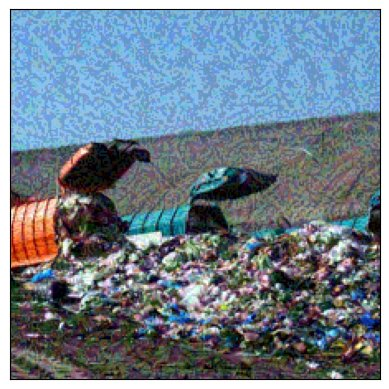

In [20]:
for perturbed_data, target in test_loader:
    # imshow(unperturbed_data.squeeze().detach().cpu().numpy()) 
    imshow(perturbed_data.squeeze().detach().cpu().numpy()) 
    break

In [ ]:
def test(model, device, test_loader, epsilon):
    correct = 0
    sub_total = 0
    start_time = time.time()
    adv_examples = []
    model.eval()
    criterion = nn.CrossEntropyLoss()

    for i, (perturbed_data, target) in enumerate(test_loader):
        # print(i)
        perturbed_data, target = perturbed_data.to(device), target.to(device)

        # Evaluate the unperturbed data
        output = model(perturbed_data)
        final_prob, final_pred = torch.nn.functional.softmax(output, dim=1).max(1) # Apply softmax to convert logits to probabilities for the whole batch, obtain the max probability and the corresponding class
        
        # Collect results
        if final_pred.item() == target.item():
            correct += 1

    final_acc = correct / float(len(test_loader))
    # failure_rate = 1-correct/sub_total
    print(f"Model Name: {model.__class__.__name__}, Test Accuracy = {correct} / {len(test_loader)} = {final_acc: .3f}, Time taken: {(time.time()-start_time)//60:.0f}m, {(time.time()-start_time)%60:.2f}s")

    return final_acc


In [22]:
model2 = models.googlenet(weights='DEFAULT')

In [ ]:
for model2 in models_list:
    model2 = model2.to(device)
    acc = test(model2, device, test_loader, 0.07)

Model Name: GoogLeNet, Test Accuracy = 3213 / 9469 =  0.339, Time taken: 4m, 16.10s
Model Name: VGG, Test Accuracy = 229 / 9469 =  0.024, Time taken: 5m, 38.47s
Model Name: ResNet, Test Accuracy = 4997 / 9469 =  0.528, Time taken: 7m, 13.66s
Model Name: ConvNeXt, Test Accuracy = 4158 / 9469 =  0.439, Time taken: 5m, 27.75s


### 4.3 Exploration of Alternate Attacks

In [ ]:
model = models.convnext_tiny(weights='DEFAULT')

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def ifgsm_attack(input,epsilon,data_grad): # https://github.com/as791/Adversarial-Example-Attack-and-Defense
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad): # https://github.com/as791/Adversarial-Example-Attack-and-Defense
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out



In [ ]:
accuracies = []
failure_rates = []
examples = []

In [ ]:
attacks = [fgsm_attack, ifgsm_attack, mifgsm_attack, jsma_attack]

In [ ]:
def test( model, device, test_loader, attack, epsilon = 0.03):

    # Accuracy counter
    correct = 0
    start_time = time.time()
    adv_examples = []

    # Counter for missclassification rate of previously correctly classified images
    sub_total = 0

    # Set the model to evaluation mode
    model.eval()

    # Use the CrossEntropyLoss: models so far have outputed raw logits (unlike tutorial which outputs log probabilites)
    criterion = nn.CrossEntropyLoss()

    # Loop over all examples in test set
    for data, target in test_loader:
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_prob, init_pred = torch.nn.functional.softmax(output, dim=1).max(1) # Apply softmax to convert logits to probabilities for the whole batch, obtain the max probability and the corresponding class

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        sub_total +=1

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = reverse_transform(data)

        # Call FGSM Attack
        perturbed_data = attack(model, data_denorm, target)

        # Reapply normalization
        perturbed_data_normalized = transform(perturbed_data).to(device)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_prob, final_pred = torch.nn.functional.softmax(output, dim=1).max(1)
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), init_prob.item(), final_pred.item(), final_prob.item(), adv_ex) )
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    failure_rate = 1-correct/sub_total
    print(f"Epsilon: {epsilon}, Test Accuracy = {correct} / {len(test_loader)} = {final_acc: .3f}, Failure Rate =  {sub_total-correct} / {sub_total} = {failure_rate: .3f},  Time taken: {(time.time()-start_time)//60:.0f}m, {(time.time()-start_time)%60:.2f}s")

    # Return the accuracy and an adversarial example
    return final_acc, failure_rate, adv_examples

In [ ]:
model = model.to(device)
for attack in attacks:
    acc, failure_rate, ex = test(model, device, test_loader, attack)
    accuracies.append(acc)
    failure_rates.append(failure_rate)

Epsilon: 0.03, Test Accuracy = 3487 / 3925 =  0.888, Failure Rate =  126 / 3613 =  0.035,  Time taken: 38m, 25.27s
Epsilon: 0.03, Test Accuracy = 3503 / 3925 =  0.892, Failure Rate =  110 / 3613 =  0.030,  Time taken: 38m, 26.24s
Epsilon: 0.03, Test Accuracy = 3503 / 3925 =  0.892, Failure Rate =  110 / 3613 =  0.030,  Time taken: 38m, 26.58s


In [ ]:
import pandas as pd
x = pd.DataFrame({'a':accuracies, 'f' :failure_rates})
x

a  \
0  [0.7829299363057325, 0.12738853503184713, 0.09...   
1  [0.8244585987261146, 0.056305732484076436, 0.0...   
2  [0.9335031847133758, 0.6430573248407643, 0.632...   
3  [0.9205095541401274, 0.9118471337579618, 0.888...   

                                                   f  
0  [0.0, 0.8372925479986983, 0.8743898470549951, ...  
1  [0.0, 0.9317058096415327, 0.9595179233621756, ...  
2  [0.0, 0.31113537117903933, 0.322325327510917, ...  
3  [0.0, 0.00941046221976194, 0.03487406587323549...

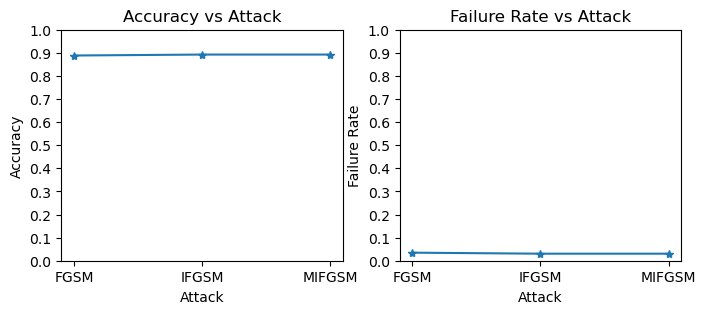

In [ ]:
def plot(accuracies, failure_rates):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(["FGSM","IFGSM","MIFGSM"], accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    # plt.xticks(np.arange(0, .35, step=0.05))
    plt.title(f"Accuracy vs Attack")
    plt.xlabel("Attack")
    plt.ylabel(f"Accuracy")

    plt.subplot(1,2,2)
    plt.plot(["FGSM","IFGSM","MIFGSM"], failure_rates, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    # plt.xticks(np.arange(0, .35, step=0.05))
    plt.title(f"Failure Rate vs Attack")
    plt.xlabel("Attack")
    plt.ylabel(f"Failure Rate")

    plt.savefig(f'appendix_attacks.pdf')
    plt.show()
for i in range(len(accuracies)):
    plot(accuracies[i], failure_rates[i])